In [1]:
#%matplotlib inline
#%matplotlib notebook #allows zooming, but opens many figures many don't respond
import os
import pyemu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.ndimage
import datetime
import flopy.utils.binaryfile as bf
from shutil import copyfile

import matplotlib.animation as animation
animation.writers.list()

flopy is installed in C:\conda3x64\envs\p3x64\lib\site-packages\flopy


['html']

In [2]:
os.getcwd()

'S:\\CarsonValley\\MSMF\\WftS_archive\\ancillary\\python'

In [3]:
help(bf)

Help on module flopy.utils.binaryfile in flopy.utils:

NAME
    flopy.utils.binaryfile

DESCRIPTION
    Module to read MODFLOW binary output files.  The module contains four
    important classes that can be accessed by the user.
    
    *  HeadFile (Binary head file.  Can also be used for drawdown)
    *  HeadUFile (Binary MODFLOW-USG unstructured head file)
    *  UcnFile (Binary concentration file from MT3DMS)
    *  CellBudgetFile (Binary cell-by-cell flow file)

CLASSES
    builtins.object
        CellBudgetFile
    flopy.utils.datafile.Header(builtins.object)
        BinaryHeader
    flopy.utils.datafile.LayerFile(builtins.object)
        BinaryLayerFile
            HeadFile
            HeadUFile
            UcnFile
    
    class BinaryHeader(flopy.utils.datafile.Header)
     |  The binary_header class is a class to create headers for MODFLOW
     |  binary files.
     |  
     |  Parameters
     |  ----------
     |      bintype : str
     |          is the type of file being 

In [4]:
#write header to raster with clipped
def rast_head(fnam):
    temp=np.loadtxt(fnam)
    np.savetxt(fnam,temp,fmt='%.6e')
    with open(fnam,'r') as f:
        temp=f.readlines()
    with open(fnam,'w+') as f:
        f.write('NCOLS 206\n')
        f.write('NROWS 258\n')
        f.write('XLLCORNER 828559.06\n')
        f.write('YLLCORNER 14076131.52\n')
        f.write('CELLSIZE 550\n')
        f.write('NODATA_VALUE -9999\n')
        for line in temp:
            line=line.replace('nan','-9999')
            f.write(line)

In [5]:
def head_dif(head,bscen,places,btag='',outdir='',size=2):
    '''if bscen is array, subtract from all but bscenin head
    if bscen is dic of arrays (e.g. MAR) find similar and use as bscen'''
    vmin=[]
    vmax=[]
    dif={}
    ibnd=np.loadtxt(r'S:\CarsonValley\MSMF\WftS_archive\model\external_files\Carson_Valley\arrays\CV-wes-8015trans-ib5.lay')
    
    #np.not_equal doesn't work here for some stupid reason, likely nan
    if type(bscen)==np.ndarray:
        hlist=sorted(list(set([h for h in finalhead if np.nanmean(np.abs(finalhead[h]-bscen))>1e-5])))
    elif type(bscen)==dict:
        hlist=sorted(list(set([h for h in bscen if btag in h])))
    if len(hlist)==1:
        hlist=hlist+hlist #just make 2, duh
    fig, axs = plt.subplots(1, len(hlist), figsize=(len(hlist)*8,8))
    print(hlist)
    for ax,scen in zip(axs,hlist):
        fnam=os.path.join(outdir,scen+'_head_dif.asc')
        if type(bscen)==np.ndarray:
            dif[scen]=sp.ndimage.filters.median_filter(head[scen]-bscen,size=size)
            if outdir!='':
                np.savetxt(fnam,dif[scen],fmt='%.6e')
                rast_head(fnam)
                print('saved raster as {}'.format(fnam))
        elif type(bscen)==dict:
            for b in bscen:
                if scen.replace(btag,'') == b:
                    print('using {} as base scenario for {}'.format(b,scen))
                    dif[scen]=sp.ndimage.filters.median_filter(head[scen]-bscen[b],size=size)
                    if outdir!='':
                        np.savetxt(fnam,dif[scen],fmt='%.6e')
                        rast_head(fnam)
                        print('saved raster as {}'.format(fnam))
    #center on 0
    for scen in dif:
        vmin.append(np.nanmin(dif[scen]))
        vmax.append(np.nanmax(dif[scen]))
    mx=int(np.ceil(np.max([np.abs(vmin)+np.abs(vmax)]))/10)*10
    vn=-mx
    vx=mx
    print(vn,vx)
    ci=5#np.max([int(np.ceil(vx/50)*5),5]) #round to next 5
    rng=[*range(0,vx,ci)]
    rng=sorted(list(set(rng+[-r for r in rng])))
    print(rng)
    
    #plot
    for ax,scen in zip(axs,sorted(list(set(dif.keys())))):
        im=ax.imshow(dif[scen],cmap='bwr_r',vmin=vn,vmax=vx,interpolation='gaussian',alpha=0.75)  

        ax.contour(dif[scen], levels=rng, colors='k')
        ax.set_title(tits[scen],fontsize=40)

        for p in places:
            ax.contour(ibnd)
            ax.scatter(*zip(places[p]['pos']),color='k')
            ax.annotate(p, places[p]['pos'], places[p]['label'],fontsize=30,arrowprops=dict(headlength=0.00000001,headwidth=5,width=1,facecolor='black', shrink=0.05))
            ax.set_yticklabels([])
            ax.set_xticklabels([])
    ax.annotate('contour\ninterval: {}'.format(ci),(142,20),fontsize=20)
    cbar = fig.add_axes()
    fig.subplots_adjust(wspace=0.001,left=0,right=1,top=1,bottom=0)
    cbar=fig.colorbar(im, cax=cbar)
    cbar.ax.tick_params(labelsize=30) 
    cbar.set_label('Change in head (ft)',size=30)
    fig.tight_layout()

    plt.show()
    return(dif)

In [6]:
places={'Minden':{'pos':(46,107),'label':(85,245)},
        'Gardnerville':{'pos':(54,117),'label':(85,225)},
        'Genoa':{'pos':(5,74),'label':(10,51)},
        'Airport':{'pos':(54,79),'label':(69,15)}}


# dT Maps
Measured ET, simulated ET (SWET+WELLET+GWET) and residual (all depth)
Surface deliveries (depth), next to priorities?
Groundwater pumping: measured, simulated, residual (annual volume)

In [7]:
scendir=r'S:\CarsonValley\MSMF\WftS_archive\output'
outdir=r'S:\CarsonValley\MSMF\results_dT'
scens={'hist':'CV-wfts-hist',
           '1C':'CV-wfts-1C',
           '2C':'CV-wfts-2C',
           '3C':'CV-wfts-3C',
           '4C':'CV-wfts-4C',
           '5C':'CV-wfts-5C'}
scenlist=sorted(list(scens.keys()))

tits = {'hist': 'Historical', '1C': '1C Increase','2C': '2C Increase',
            '3C': '3C Increase', '4C': '4C Increase', '5C': '5C Increase'}    
#'3C':'CV-wfts-3C',

In [8]:
# get head
head={}
difhead={}
inithead={}
finalhead={}
nmkstplist=[]
for scen in scens:
    headfile=os.path.join(scendir,'output_MSGSF_'+scen,'CV-wes-8015trans-closest-'+scen+'.bheds')
    head[scen]=bf.HeadFile(headfile)
    kstpkper=head[scen].get_kstpkper()
    nmkstplist.append(len(kstpkper)-1)
    print(len(kstpkper),kstpkper[0],kstpkper[-1])
# scens have variable kstpkper while running
nmeankstp=np.min(nmkstplist)
print(nmkstplist)

474 (0, 0) (0, 1890)
474 (0, 0) (0, 1890)
474 (0, 0) (0, 1890)
474 (0, 0) (0, 1890)
474 (0, 0) (0, 1890)
474 (0, 0) (0, 1890)
[473, 473, 473, 473, 473, 473]


In [9]:
# difference between final and initial heads 
for scen in scenlist:
    #define initial
    b=[]
    initstp=(52,104)
    for i in kstpkper[initstp[0]:initstp[1]]:
        initlays=head[scen].get_data(kstpkper=i) #nlay,nrow,ncol
        a=np.where(initlays >0,initlays,np.nan) #replace <0 with nans
        b.append(np.nanmean(a,axis=0)) #mean without nans
    inithead[scen]=np.nanmean(b,axis=0)

    #define final
    b=[]
    finstp=(-52,-1)
    for i in kstpkper[finstp[0]:finstp[1]]:
        finallays=head[scen].get_data(kstpkper=i)
        a=np.where(finallays >0,finallays,np.nan)
        b.append(np.nanmean(a,axis=0)) #mean without nans
    finalhead[scen]=np.nanmean(b,axis=0)


['1C', '2C', '3C', '4C', '5C', 'hist']
using 1C as base scenario for 1C
using 2C as base scenario for 2C
using 3C as base scenario for 3C
using 4C as base scenario for 4C
using 5C as base scenario for 5C
using hist as base scenario for hist
-570 570
[-565, -560, -555, -550, -545, -540, -535, -530, -525, -520, -515, -510, -505, -500, -495, -490, -485, -480, -475, -470, -465, -460, -455, -450, -445, -440, -435, -430, -425, -420, -415, -410, -405, -400, -395, -390, -385, -380, -375, -370, -365, -360, -355, -350, -345, -340, -335, -330, -325, -320, -315, -310, -305, -300, -295, -290, -285, -280, -275, -270, -265, -260, -255, -250, -245, -240, -235, -230, -225, -220, -215, -210, -205, -200, -195, -190, -185, -180, -175, -170, -165, -160, -155, -150, -145, -140, -135, -130, -125, -120, -115, -110, -105, -100, -95, -90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110

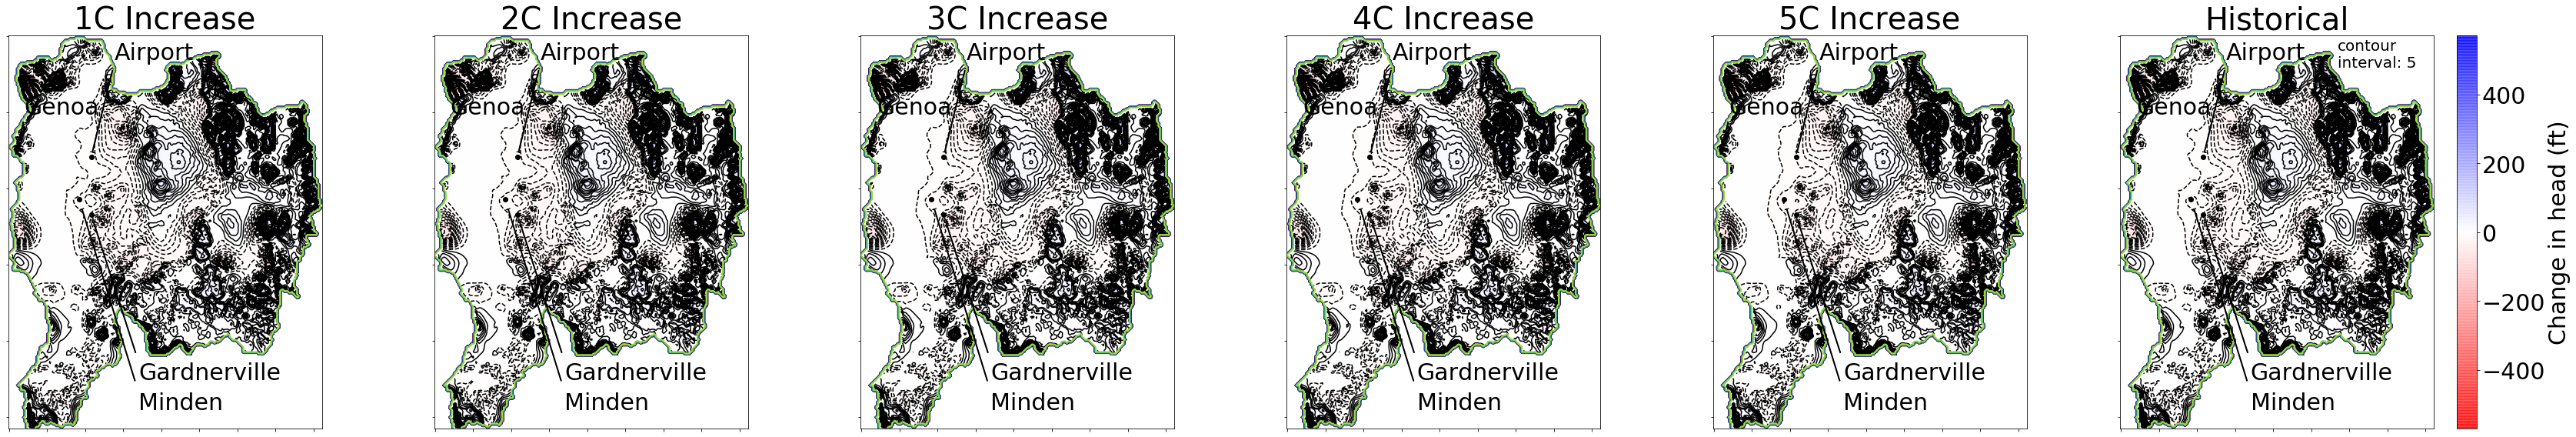

In [10]:
pdif=head_dif(finalhead,inithead,places) #change over simulation

In [11]:
np.equal(finalhead['1C'],finalhead['2C']).all()

False

In [12]:
np.equal(finalhead['1C'],finalhead['3C']).all()

False

In [13]:
np.equal(finalhead['1C'],finalhead['hist']).all()

False

['1C', '2C', '3C', '4C', '5C']
saved raster as S:\CarsonValley\MSMF\results_dT\1C_head_dif.asc
saved raster as S:\CarsonValley\MSMF\results_dT\2C_head_dif.asc
saved raster as S:\CarsonValley\MSMF\results_dT\3C_head_dif.asc
saved raster as S:\CarsonValley\MSMF\results_dT\4C_head_dif.asc
saved raster as S:\CarsonValley\MSMF\results_dT\5C_head_dif.asc
-30 30
[-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25]


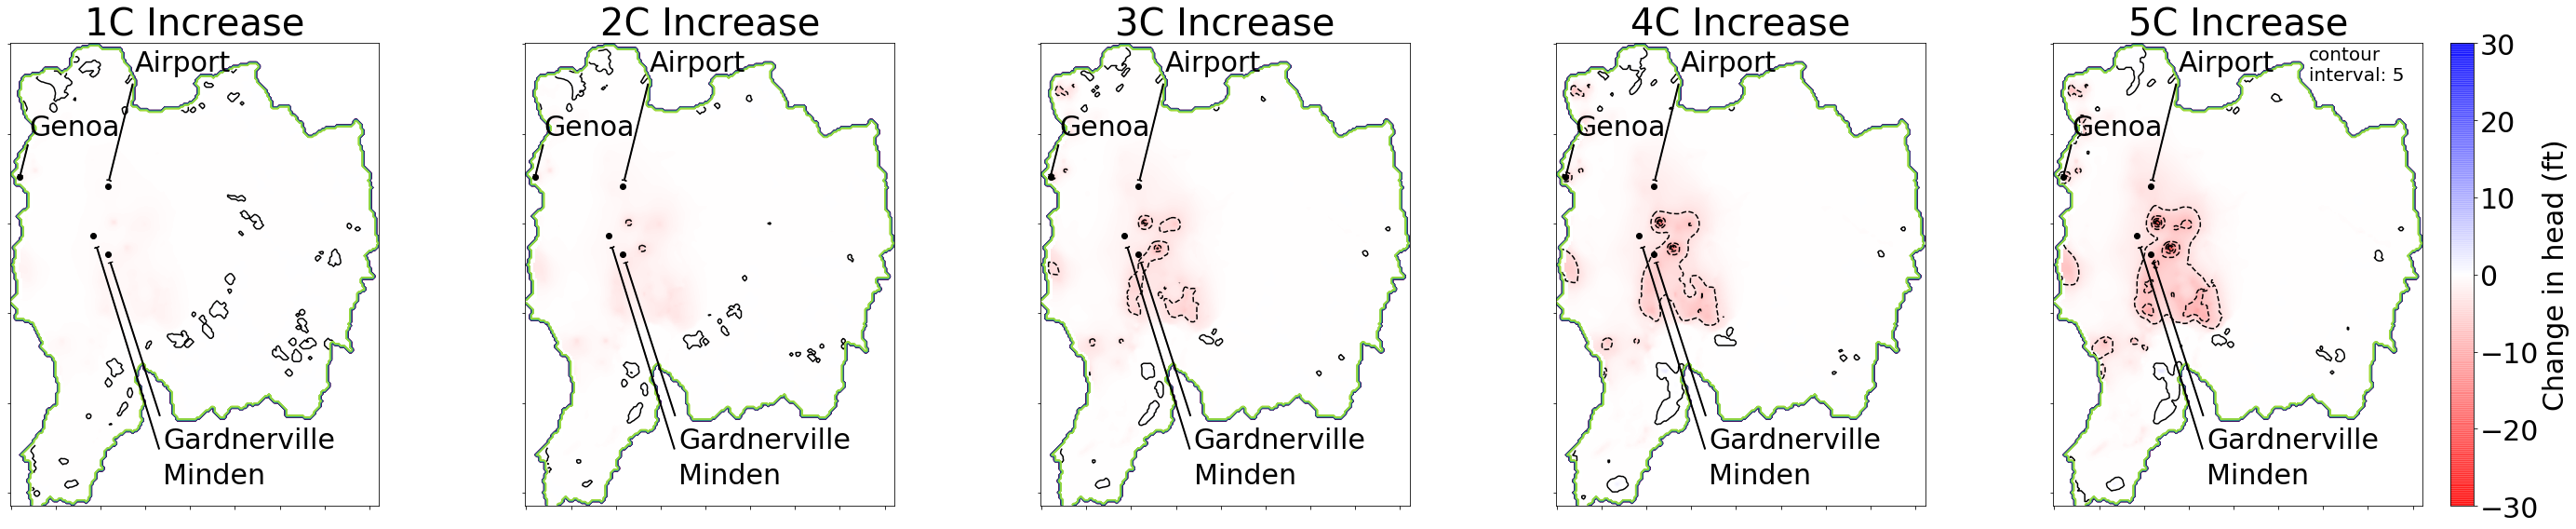

In [14]:
hdif=head_dif(finalhead,finalhead['hist'],places,outdir=outdir)

In [15]:
for scen in hdif:
    print(scen,np.nanmin(hdif[scen]))


1C -3.6958008
2C -8.727539
3C -15.744629
4C -23.461426
5C -29.554688


# MAR head differences

In [44]:
scendir=r'S:\CarsonValley\MSMF\scenarios_191029\MAR191029\runs'
outdir=r'S:\CarsonValley\MSMF\scenarios_191029\MAR191029\\results_MAR'
scens={'hifreq':'CV-wfts-hifreq',
      'hifreqMAR':'CV-wfts-hifreqMAR'}
      #'histPRMS': 'CV-wfts-histPRMS',
      #'histPRMSMAR': 'CV-wfts-histPRMSMAR'}
scenlist=sorted(list(scens.keys()))

tits = {'hifreqMAR':'GCM climate with MAR','hifreq':'GCM climate'}#,'lofreqMAR':'Low frequency MAR','histPRMSMAR':'Historical MAR'}
#,
#'hifreq':'High frequency','lofreq':'Low frequency','histPRMS':'Historical'} 

In [45]:
# get head
head={}
difhead={}
inithead={}
finalhead={}
nmkstplist=[]
for scen in scens:
    print(scen)
    headfile=os.path.join(scendir,scens[scen],'output','CV-wes-8015trans-closest-nl.bheds')
    head[scen]=bf.HeadFile(headfile)
    kstpkper=head[scen].get_kstpkper()
    nmkstplist.append(len(kstpkper)-1)
    print(len(kstpkper),kstpkper[0],kstpkper[-1])
# scens have variable kstpkper while running
nmeankstp=np.min(nmkstplist)
print(nmkstplist)


hifreq
261 (0, 851) (0, 1890)
hifreqMAR
261 (0, 851) (0, 1890)
[260, 260]


In [46]:
# difference between final and initial heads 
for scen in scenlist:
    print(scen)
    #define initial
    b=[]
    initstp=(52,104)
    for i in kstpkper[initstp[0]:initstp[1]]:
        initlays=head[scen].get_data(kstpkper=i) #nlay,nrow,ncol
        a=np.where(initlays >0,initlays,np.nan) #replace <0 with nans
        b.append(np.nanmean(a,axis=0)) #mean without nans
    inithead[scen]=np.nanmean(b,axis=0)

    #define final
    b=[]
    finstp=(-52,-1)
    for i in kstpkper[finstp[0]:finstp[1]]:
        finallays=head[scen].get_data(kstpkper=i)
        a=np.where(finallays >0,finallays,np.nan)
        b.append(np.nanmean(a,axis=0)) #mean without nans
    finalhead[scen]=np.nanmean(b,axis=0)


hifreq
hifreqMAR


['hifreq', 'hifreqMAR']
using hifreq as base scenario for hifreq
using hifreqMAR as base scenario for hifreqMAR
-230 230


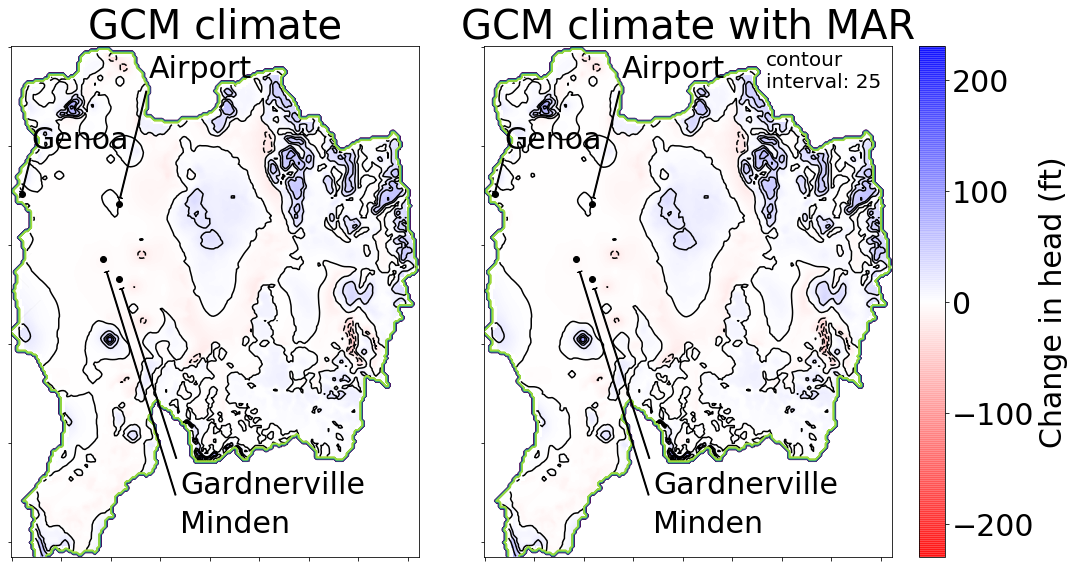

In [47]:
pdif=head_dif(finalhead,inithead,places) #change over simulation

['hifreqMAR', 'hifreqMAR']
using hifreq as base scenario for hifreqMAR
saved raster as S:\CarsonValley\MSMF\scenarios_191029\MAR191029\\results_MAR\hifreqMAR_head_dif.asc
using hifreq as base scenario for hifreqMAR
saved raster as S:\CarsonValley\MSMF\scenarios_191029\MAR191029\\results_MAR\hifreqMAR_head_dif.asc
-30 30


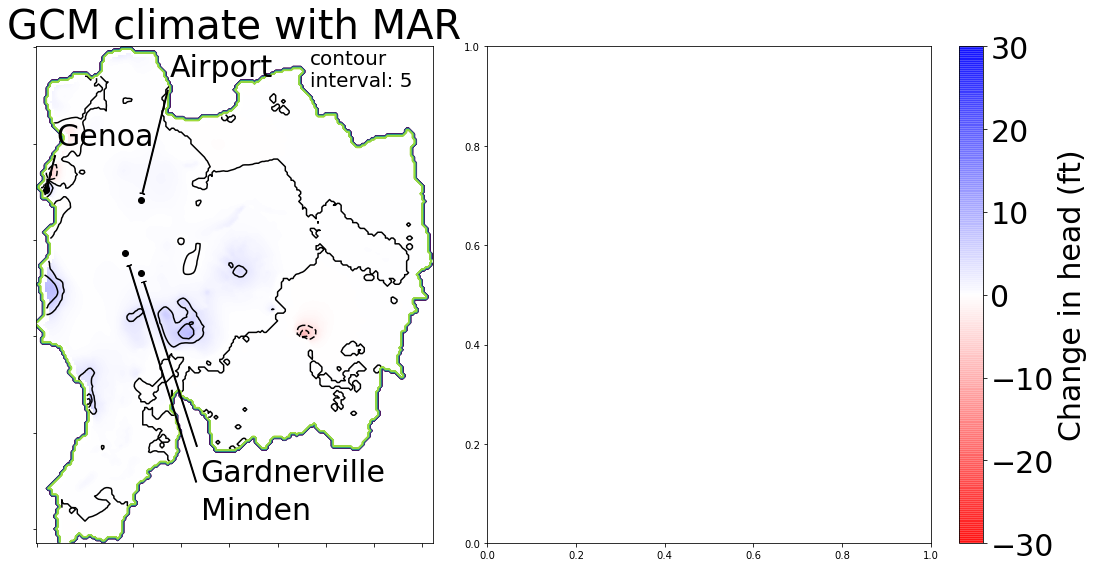

In [48]:
hdif=head_dif(finalhead,finalhead,places,btag='MAR',outdir=outdir)

# attempt to animate
Writer = animation.writers['html']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#difference in head between histPRMS and scen
hdifhead={}
ims=[]

fig, axs = plt.subplots(1,6,figsize=(30, 5))

scenhead={}

for i in rng:
    fig.suptitle('Simulation head differences from histPRMS for stress period {}'.format(kstpkper[i]))

    for ax,scen in zip(axs,scens): 
        #basehead
        baselays=head['histPRMS'].get_data(kstpkper=kstpkper[i]) #nlay,nrow,ncol
        a=np.where(baselays >0,baselays,np.nan) #replace <0 with nans
        basehead=np.nanmean(a,axis=0) #mean without nans


        scenlays=head[scen].get_data(kstpkper=kstpkper[i])
        a=np.where(scenlays >0,scenlays,np.nan)
        #b=np.nanmean(a,axis=0)-basehead #mean without nans
    
        im=ax.imshow(,vmin=-20, vmax=0,cmap='plasma_r', animated=True)
        #ax.colorbar(im,ax=ax)
        for x,y in tits.items():
            if x in scen:
                tit = scen.replace(x, y)
        ax.set_title(tit)
        ims.append([im])
ani=animation.ArtistAnimation(fig,ims,interval=50,blit=True)
ani.save(os.path.join(scendir,'scen-histPRMS_movie.html'),writer=writer)
plt.show()

In [ ]:
for scen in scenlist:
    cbcfile=os.path.join(scens[scen],'output','CV-wes-8015trans-closest-nl.cbc')
    cbc=bf.CellBudgetFile(cbcfile)
    kstpkper=cbc.get_kstpkper()
    recs=cbc.get_unique_record_names()
    
    head[scen].close()

In [ ]:
recs
#[b'           GW ET',
# b'    UZF RECHARGE',
# b' SURFACE LEAKAGE',
# b'       HORT+DUNN',
# b'  STORAGE CHANGE']

In [ ]:
maxwidth=10
mask=np.ones((258,206))
mask[0:30,100:206]=0
mask[0:100,150:206]=0
mask[0:200,150:206]=0
ibnd=np.loadtxt(r'S:\CarsonValley\MSMF\scenarios_volume\CV-wfts-historical\arrays\CV-wes-8015trans-ib5.lay')
for scen in scens:
    if 'MAR' in scen:
        print(scen)
        nomarscen=scen.replace('MAR','')
        bscen='histPRMS'
        nomar=finalhead[nomarscen]-finalhead[bscen]
        mar=finalhead[scen]-finalhead[bscen]
        w,h=maxwidth,(nomar.shape[0]*maxwidth)/(3*nomar.shape[1])
        fig, axs = plt.subplots(1, 2, figsize=(w,h))
        fig.subplots_adjust(wspace=0.5,left=0,right=1,top=1,bottom=0)
        
        im0=axs[0].imshow(nomar,cmap='bwr_r',vmin=-20,vmax=20,interpolation='gaussian',alpha=0.75)
        
        plt.colorbar(im0,orientation='horizontal')
        plt.show()
        im1=axs[1].imshow(mar,cmap='bwr_r',vmin=-20,vmax=20,interpolation='gaussian',alpha=0.75)
        im2=axs[2].imshow(mar-nomar,cmap='bwr_r',vmin=-20,vmax=20,interpolation='gaussian',alpha=0.75)
        axs[0].contour(nomar*mask, range(-50,20,10), colors='k')
        axs[1].contour(mar*mask, range(-50,20,10), colors='k')
        axs[2].contour(mar*mask-nomar*mask, range(-50,20,10), colors='k')
        for x,y in tits.items():
            if x in scen:
                tit = scen.replace(x, y)
        
        axs[0].set_title(tit.replace('MAR',''),fontsize=20)
        axs[1].set_title(tit.replace('MAR','  MAR'),fontsize=20)
        axs[2].set_title('{}:\n MAR minus noMAR'.format(tit.replace('MAR','')),fontsize=20)
        
        for p in places:
            for ax in axs:
                ax.contour(ibnd)
                ax.scatter(*places[p][0],c='g',s=40)
                ax.annotate(p, places[p][0],xytext=places[p][1],fontsize=10,arrowprops=dict(frac=0.00000001,headwidth=5,width=1,facecolor='black', shrink=0.05))
                ax.set_yticklabels([])
                ax.set_xticklabels([])
            
        #fig.tight_layout()
        plt.show()

In [ ]:
hdobj.to_shapefile('test_heads_sp6.shp', totim=times[-1])

In [ ]:
# Check layers

In [ ]:
os.getcwd()

In [ ]:
Lbot={}
for f in os.listdir('arrays'):
    if 'BOTN' in f: #only "new" layers
        lay=int(f.split('BOTN')[-1].replace('.lay',''))
        print('BOTN {}'.format(lay))
        Lbot[lay]=np.loadtxt(os.path.join('arrays',f))
    elif 'BOT' in f and 'BOTA' not in f:
        lay=int(f.split('-BOT')[-1].replace('.lay',''))
        print('BOT {}'.format(lay))
        Lbot[lay]=np.loadtxt(os.path.join('arrays',f))

In [ ]:
for lay in range(1,6):    
    plt.imshow(Lbot[lay-1]-Lbot[lay])
    plt.colorbar()
    plt.title('layer {} thickness'.format(lay))
    plt.show()
    plt.imshow(Lbot[lay])
    plt.colorbar()
    plt.title('layer {} bottom altitude'.format(lay))
    plt.show()

In [ ]:
ic={}
for f in os.listdir('arrays'):
    if 'ICN' in f: #only "new" layers
        lay=int(f.split('ICN')[-1].replace('.dat',''))
        print(lay)
        ic[lay]=np.loadtxt(os.path.join('arrays',f))

In [ ]:
for lay in range(1,6):    
    plt.imshow(ic[lay])
    plt.colorbar()
    plt.title('layer {} initial head'.format(lay))
    plt.show()

In [ ]:
ib={}
for f in os.listdir('arrays'):
    if 'ib' in f: #only "new" layers
        lay=int(f.split('ib')[-1].replace('.lay',''))
        print(lay)
        ib[lay]=np.loadtxt(os.path.join('arrays',f))

In [ ]:
for lay in range(1,6):    
    plt.imshow(ib[lay])
    plt.colorbar()
    plt.title('layer {} ibound'.format(lay))
    plt.show()

In [ ]:
zone={}
for f in os.listdir('arrays'):
    if '.zon' in f: #only "new" layers
        lay=int(f.split('lay')[-1].replace('.zon',''))
        print(lay)
        zone[lay]=np.loadtxt(os.path.join('arrays',f))

In [ ]:
for lay in range(1,6):    
    plt.imshow(zone[lay])
    plt.colorbar()
    plt.title('layer {} geology'.format(lay))
    plt.show()